In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [9]:
batch_size = 48

img_height = 150
img_width = 150

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [11]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


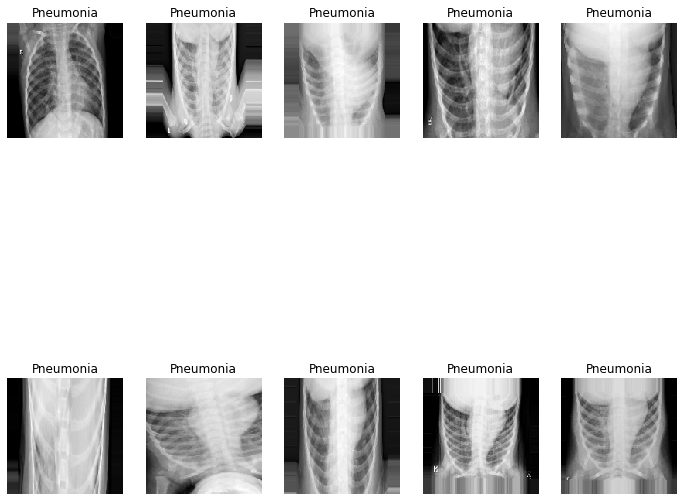

In [12]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, SeparableConv2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [14]:
model = Sequential()

model.add(SeparableConv2D(32,(3,3),input_shape=(img_width,img_height,1),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(32,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(64,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(64,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(128,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(128,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(256,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(256,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

# model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(activation='sigmoid',units=1))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 148, 148, 32)      73        
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
elu (ELU)                    (None, 148, 148, 32)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 146, 146, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
elu_1 (ELU)                  (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0

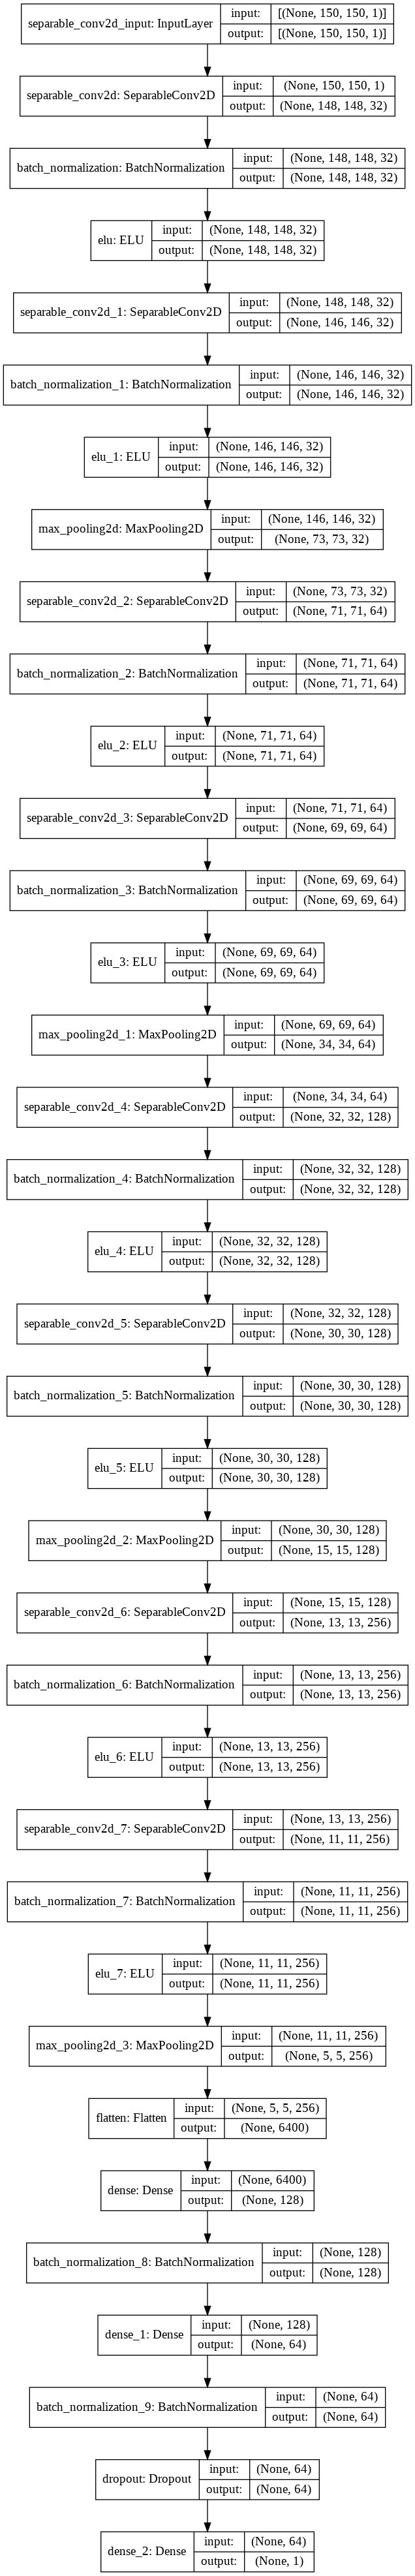

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [17]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [18]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [19]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
88/88 [==============================] - 60s 627ms/step - loss: 0.4557 - accuracy: 0.7775 - val_loss: 0.5742 - val_accuracy: 0.7433
Epoch 2/25
88/88 [==============================] - 54s 617ms/step - loss: 0.3232 - accuracy: 0.8595 - val_loss: 0.6461 - val_accuracy: 0.7433
Epoch 3/25
88/88 [==============================] - 55s 618ms/step - loss: 0.2702 - accuracy: 0.8855 - val_loss: 0.8122 - val_accuracy: 0.7433
Epoch 4/25
88/88 [==============================] - 54s 614ms/step - loss: 0.2386 - accuracy: 0.9047 - val_loss: 1.0204 - val_accuracy: 0.7433
Epoch 5/25
88/88 [==============================] - 54s 613ms/step - loss: 0.2244 - accuracy: 0.9103 - val_loss: 1.7459 - val_accuracy: 0.7433
Epoch 6/25
88/88 [==============================] - 54s 614ms/step - loss: 0.1993 - accuracy: 0.9155 - val_loss: 1.4702 - val_accuracy: 0.7433
Epoch 7/25
88/88 [==============================] - 54s 612ms/step - loss: 0.1722 - accuracy: 0.9387 - val_loss: 0.9056 - val_accuracy: 0.7452

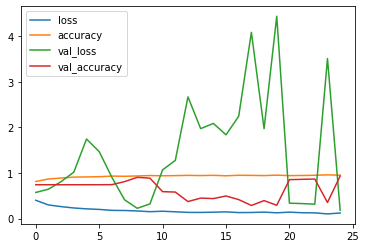

In [20]:
pd.DataFrame(model.history.history).plot()

In [21]:
test_accu = model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

13/13 [==============================] - 4s 285ms/step - loss: 0.2288 - accuracy: 0.9215
The testing accuracy is -  92.14743375778198 %


In [22]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [23]:
y_bar = np.round(model.predict(test)).reshape(-1)
y_act = test.labels

In [24]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9214743589743589
ROC-AUC score:  0.9358974358974358
F1 score:  0.9401709401709403
Log Loss:  2.7121859636823316


In [25]:
model.save('custom_cnn.h5')